# Cat Classification Model Development
# 1. Project Overview
This notebook implements and evaluates machine learning models for classifying images containing either Lacta, Karamela, or both cats. The project follows a systematic approach to model development, starting with a simple baseline and progressing to advanced techniques to address the specific challenges identified in our data exploration.

## 1.1 Data Exploration Insights & Challenges
Our comprehensive data analysis revealed several critical characteristics that directly inform our modeling strategy:

**Key Challenges Identified**
- Class Imbalance: Significant under-representation of the "both" class (15.6% vs 49.3% Lacta, 35.2% Karamela) requiring specialized handling

- Color Biases: Systematic brightness and color temperature differences between classes that could lead to model shortcuts

- Visual Complexity: Diverse poses, scales, and occlusions demanding robust feature learning capabilities

- Background Variations: Differing environmental contexts that may create spurious correlations

**Mitigation Strategies**
- Output Architecture: A three-class softmax output layer designed to directly learn spatial relationships for detecting multiple cats.

- Stratified Data Splits: Maintained proportional class representation (70/15/15) across all datasets to preserve distribution.

- Consistent Evaluation Framework: The same data splits are used for all models to ensure fair and comparable evaluations.

## 1.2 Modeling Approach
This notebook documents our progressive model development:

1. Baseline CNN: Establish a performance benchmark and validate our data pipeline. This model serves as a diagnostic tool to isolate data issues from model capacity limitations.

2. Transfer Learning: Leverage pre-trained models (e.g., ResNet, EfficientNet) to address the complex feature learning challenges posed by varied poses and lighting.

3. Advanced Techniques: Implement methods like class weighting and data augmentation specifically targeting the class imbalance and identified biases.

The prepared dataset with 546 images (Train: 380, Val: 83, Test: 83) serves as the consistent foundation for all experiments, enabling direct comparison between approaches and clear measurement of improvements.

# 2. Prerequisites
## 2.1 Imports

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.utils.class_weight import compute_class_weight

import numpy as np

import os
from dataclasses import dataclass, field
from typing import List

import sys
sys.path.append('../src')

import importlib
import config_class
importlib.reload(config_class)

from model_evaluation import visualize_training_history, evaluate_model
from config_class import ConfigClass

print("=== IMPORTS FINISHED ===")

=== IMPORTS FINISHED ===


## 2.2 Constants

In [2]:
DATA_PATH = '../data/processed'
MODEL_PATH = '../models'

# Image Processing
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3
BATCH_SIZE = 32
RANDOM_SEED = 42

# 3. Data Preparation

## 3.1 Data Augmentation Configuration
We implement distinct data processing pipelines for training versus evaluation.
The training generator employs extensive data augmentation to combat overfitting and improve model robustness, which is particularly crucial for amplifying the underrepresented 'both' class. The chosen parameters reflect realistic photographic variations while avoiding extreme distortions that would create implausible cat images. Specifically, the brightness_range parameter helps mitigate the color temperature biases identified during data exploration.
Meanwhile, the validation and test generators perform only pixel normalization to ensure unbiased evaluation metrics that reflect true model generalization. We maintain separate generators for validation and testing to ensure consistent preprocessing across all evaluation phases and prevent any data leakage between splits.

In [3]:
def create_data_generators(
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
):
    """
    Creates separate data generators for training, validation, and test sets.
    Training data is heavily augmented, while validation/test data is only normalized.
    """
    # Training generator with heavy augmentation for minority classes
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.3,
        height_shift_range=0.3,
        horizontal_flip=True,
        zoom_range=0.3,
        brightness_range=[0.7, 1.3],
        shear_range=0.1,
        fill_mode='nearest'
    )
    
    val_datagen = ImageDataGenerator(rescale=1./255)

    test_datagen = ImageDataGenerator(rescale=1./255)
    
    return train_datagen, val_datagen, test_datagen

## 3.2. Creating Data Generators
With our augmentation strategy defined, we instantiate the data generators for training, validation, and testing. These generators handle image resizing, batch processing, and real-time augmentation during model training. The training generator uses shuffling to present the data in a random order for each epoch, which improves learning and prevents the model from memorizing the order of images. Conversely, the validation and test generators disable shuffling to ensure deterministic results and a reliable, consistent evaluation across runs.

In [4]:
train_datagen, val_datagen, test_datagen = create_data_generators()

# Create data generators
print("--- Train Generator ---")
train_generator = train_datagen.flow_from_directory(
    f'{DATA_PATH}/train',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, # Shuffle for training to prevent order memorization
    seed=RANDOM_SEED
)

print("--- Validation Generator ---")
val_generator = val_datagen.flow_from_directory(
    f'{DATA_PATH}/val', 
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False # No shuffle for consistent evaluation
)

print("--- Test Generator ---")
test_generator = test_datagen.flow_from_directory(
    f'{DATA_PATH}/test',
    target_size=(IMG_HEIGHT, IMG_WIDTH), 
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False # No shuffle for consistent evaluation
)

# Verifies all generators have the same classes
assert train_generator.class_indices == val_generator.class_indices == test_generator.class_indices, "Class indices mismatch between generators!"

# Gets class mapping from the training generator
baseline_classes = train_generator.class_indices
print(f"\nClass mapping: {baseline_classes}")

# Prints dataset statistics
print("\n--- Dataset Statistics ---")
print(f"Training samples:   {train_generator.samples:4d}")
print(f"Validation samples: {val_generator.samples:4d}")
print(f"Test samples:       {test_generator.samples:4d}")

--- Train Generator ---
Found 380 images belonging to 3 classes.
--- Validation Generator ---
Found 83 images belonging to 3 classes.
--- Test Generator ---
Found 83 images belonging to 3 classes.

Class mapping: {'both': 0, 'karamela': 1, 'lacta': 2}

--- Dataset Statistics ---
Training samples:    380
Validation samples:   83
Test samples:         83


## 3.3 Class Weights

To mitigate the class imbalance identified during exploration, we implement class weighting using scikit-learn's `compute_class_weight` function. This technique increases the loss penalty for misclassifying minority class examples, forcing the model to allocate more learning capacity to underrepresented categories.

We employ the 'balanced' strategy, which calculates weights inversely proportional to class frequencies:

class_weight = total_samples / (classes_count * class_frequency)

This ensures the model doesn't converge to a trivial majority-class predictor and learns meaningful features for all three classes.

We chose class weighting over oversampling because it doesn't increase training time or risk overfitting on synthetic examples, while still providing strong incentives for the model to learn minority class patterns.

In [5]:
temp_class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(temp_class_weights))

print("Class weights:\n", class_weights)

Class weights:
 {0: np.float64(2.146892655367232), 1: np.float64(0.945273631840796), 2: np.float64(0.6773618538324421)}


### Class Weight Analysis

The calculated class weights reflect our dataset's imbalance:

- **'both' (class 0)**: 2.14× weighting - Strong compensatory emphasis for our most underrepresented class
- **'karamela' (class 1)**: 0.95× weighting - Near-balanced representation  
- **'lacta' (class 2)**: 0.68× weighting - Reduced emphasis on the majority class

These multiplicative factors will scale the loss function during training, effectively rebalancing the learning signal. This ensures that misclassifying a 'both' example carries approximately 3.15× (2.14/0.68) greater penalty than misclassifying a 'lacta' example, encouraging the model to develop robust features for all classes despite their uneven distribution.

# 4. Baseline Model Development

This section focuses on establishing a fundamental performance benchmark for our cat classification task through the implementation of a simple Convolutional Neural Network (CNN). The baseline model serves as a critical reference point that will guide all subsequent model improvements and architectural decisions.

In this section, we will systematically:

- Select an appropriate CNN architecture that balances simplicity with learning capacity

- Implement modular model creation functions to ensure reproducibility and enable efficient experimentation

- Define an initial configuration based on established practices and our specific dataset characteristics

- Train and evaluate the baseline model to establish performance metrics that will inform our optimization strategy

The baseline approach allows us to isolate fundamental challenges—particularly class imbalance and limited training data—from architectural complexity, providing clear direction for the advanced techniques we will apply in later stages of the project.

## 4.1 Model Architecture and Training Configuration
This section defines the core components for our baseline training experiments. We implement a function to create the CNN architecture based on a configuration dictionary, alongside a complementary function to generate the training callbacks. This modular approach ensures all key aspects of the experiment—from model structure to the training dynamics—are centrally configured and easily reproducible.

### Core Architectural Pattern
We select a sequential convolutional neural network with three convolutional blocks followed by a classification head. This proven architecture provides a strong foundation for image classification tasks while maintaining simplicity for our baseline.

#### Fixed Architectural Components
1. **Convolutional Backbone Structure**
- Three Convolutional Blocks: Fixed depth that balances complexity and trainability on our dataset size

- 3×3 Kernel Size: Standard receptive field that captures local patterns efficiently while minimizing parameters

- ReLU Activation: Provides non-linearity with proven performance and avoids vanishing gradient issues

- 'same' Padding: Preserves spatial dimensions through convolutional operations

2. **Spatial Hierarchy Design**
- MaxPooling Layers: Using 2×2 pooling after each convolutional block

- Fixed Reduction Pattern: Each block reduces spatial dimensions by half while increasing feature depth

3. **Classification Head Architecture**
- Global Flattening: We use a Flatten layer rather than Global Average Pooling to preserve all spatial information for this baseline model, as our dataset is small and feature-rich.

- Single Dense Layer: Maintains simplicity while providing non-linear feature combination. Provides sufficient capacity for our 3-class problem without introducing excessive parameters that could lead to overfitting on our dataset of ~380 training images.

- Dropout Layer: Essential regularization technique for our small dataset

- Softmax Output: Appropriate for multi-class classification across our 3 categories

4. **Training Foundation**
- Adam Optimizer: Established adaptive learning rate method with proven convergence

- Categorical Crossentropy: Standard loss function for multi-class classification problems

#### Why These Fixed Choices?
These architectural decisions represent established best practices in CNN design:

- 3×3 convolutions are the building blocks of modern CNNs (VGG principle)

- Three blocks provide sufficient depth for feature hierarchy without overcomplicating our baseline

- ReLU remains the most widely used and reliable activation function

- Adam optimizer offers robust performance across diverse problems

This structure ensures our baseline is comparable to standard implementations while leaving room for hyperparameter optimization

The specific filter counts, layer sizes, learning rates, and regularization strengths will be defined as tunable hyperparameters in the next section.

5. **Training Strategy & Callbacks**

- Early Stopping: Monitors validation loss to prevent overfitting and optimize training time

- Model Checkpointing: Automatically saves the best-performing model based on validation accuracy

- Learning Rate Scheduling: Reduces learning rate when validation loss plateaus to facilitate finer convergence

- Multi-metric Monitoring: Tracks loss, accuracy, precision, and recall for comprehensive evaluation

## 4.2 Model Implementation
We now implement the architectural decisions outlined in the previous section through three modular functions. This design ensures reproducibility and facilitates systematic experimentation by centralizing all model configuration.

`create_baseline_model(config)`: Constructs the sequential CNN architecture using the filter sizes specified in the configuration. The three convolutional blocks with increasing filter counts are designed to capture a hierarchy of features from simple edges to complex patterns.

`compile_baseline_model(model, config)`: Configures the model's training process by setting the optimizer with its learning rate, the loss function, and evaluation metrics. We track accuracy, precision, and recall to get a comprehensive view of model performance.

`create_baseline_training_callbacks(config, i)`: Defines the training dynamics. EarlyStopping halts training when validation loss stops improving, ModelCheckpoint saves the best model, and ReduceLROnPlateau refines the learning rate for better convergence. The i parameter allows saving multiple experiment runs.

In [6]:
def create_baseline_model(
    config
):
    """
    Create a simple CNN baseline model
    """
    model = models.Sequential([
        layers.InputLayer(
            shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
        ),
        
         # First convolutional block - basic feature detection
        layers.Conv2D(
            filters=config.conv_filters[0], 
            kernel_size=(3, 3),
            activation='relu',
            padding='same',
        ),
        layers.MaxPooling2D(pool_size=(2, 2)),
        
         # Second convolutional block - intermediate features
        layers.Conv2D(
            filters=config.conv_filters[1],
            kernel_size=(3, 3),
            activation='relu',
            padding='same',
        ),
        layers.MaxPooling2D(pool_size=(2, 2)),
        
        # Third convolutional block - complex pattern recognition
        layers.Conv2D(
            filters=config.conv_filters[2],
            kernel_size=(3, 3),
            activation='relu',
            padding='same',
        ),
        layers.MaxPooling2D(pool_size=(2, 2)),
        
        # Classification head
        layers.Flatten(),
        layers.Dense( units=config.dense_units, activation='relu'),
        layers.Dropout(config.dropout_rate),
        
        # Output layer - 3 classes with softmax probability distribution
        layers.Dense(units=3, activation='softmax') # lacta, karamela, both
    ])
    
    return model

# Create and compile the model
def compile_baseline_model(model, config):
    """
    Compile the baseline model with appropriate settings
    """
    model.compile(
        optimizer=Adam(learning_rate=config.learning_rate),
        loss='categorical_crossentropy',  # Categorical since we have 3 classes
        metrics=['accuracy', 
                 tf.keras.metrics.Precision(name='precision'),
                 tf.keras.metrics.Recall(name='recall')]
    )
    
    return model

def create_baseline_training_callbacks(config, i):
    """Create standardized training callbacks for consistent experimentation"""
    return [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=config.early_stopping_patience,
            restore_best_weights=True,
            verbose=1
        ),
        tf.keras.callbacks.ModelCheckpoint(
            filepath=os.path.join(MODEL_PATH, f'baseline_model_{i}.keras'),
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=config.reduce_lr_factor,
            patience=config.reduce_lr_patience,
            min_lr=config.reduce_lr_min,
            verbose=1
        )
    ]

## 4.3 Initial Basline Hyperparameter Configuration
This subsection defines the initial hyperparameter values for our baseline model and explains the rationale behind each choice based on our specific problem characteristics.

### TrainingConfig Class Design
Our TrainingConfig dataclass serves as a centralized configuration manager with update functionality, enabling:

- Reproducible experiments through versioned configurations

- Systematic hyperparameter tuning via the update() method

- Clean experimentation workflow with reset and copy capabilities

- Organized parameter management separating tunable values from fixed architecture

### Initial Hyperparameter Values & Rationale
**Training Schedule**
- learning_rate = 1e-4: Conservative starting point to ensure stable convergence given our small dataset and class imbalance

- epochs = 25: Sufficient to observe learning trends while allowing early stopping to prevent overfitting

**Model Capacity & Regularization**
- conv_filters = [32, 64, 128]: Progressive filter increase following CNN best practices, starting with sufficient capacity for basic feature detection

- dense_units = 64: Reduced from typical values to prevent overparameterization given our 3-class output and limited data

- dropout_rate = 0.5: Standard regularization strength to mitigate overfitting risks from our small training set

**Training Optimization Parameters**

- early_stopping_patience = 5: Allows sufficient epochs for the model to overcome temporary plateaus while preventing overfitting

- reduce_lr_patience = 3: Balances responsive learning rate adaptation with stable training periods

- reduce_lr_factor = 0.2: Provides moderate learning rate reduction to escape local minima without losing learned features

- reduce_lr_min = 1e-7: Sets a reasonable lower bound for learning rate decay to maintain the ability to make fine weight adjustments even in late training stages.

**Problem-Specific Considerations**
These values are intentionally conservative to address our key challenges:

- Class imbalance (15% "both" class) necessitates careful learning dynamics

- Small dataset size (546 images) requires strong regularization and modest model capacity

- Fine-grained classification (similar cat appearances) demands stable, gradual learning

This configuration provides a sensible starting point that we can systematically optimize in subsequent experiments.

In [7]:
@dataclass
class BaselineConfig(ConfigClass):
    # Training
    learning_rate: float = 1e-4
    epochs: int = 25
    
    # Model Architecture
    conv_filters: List[int] = field(default_factory=lambda: [32, 64, 128])
    dense_units: int = 64
    dropout_rate: float = 0.5

    # Training Callback
    early_stopping_patience: int = 5
    reduce_lr_patience: int = 3
    reduce_lr_factor: float = 0.2
    reduce_lr_min: float = 1e-7

baseline_config_base = BaselineConfig()
print(baseline_config_base)

BaselineConfig:
  learning_rate: 0.0001
  epochs: 25
  conv_filters: [32, 64, 128]
  dense_units: 64
  dropout_rate: 0.5
  early_stopping_patience: 5
  reduce_lr_patience: 3
  reduce_lr_factor: 0.2
  reduce_lr_min: 1e-07


## 4.4 Initial Baseline Model Training and Evaluation
This section documents the execution of our first complete training experiment using the configured baseline model. We proceed through three critical phases: model instantiation, the training process with monitored callbacks, and finally, a comprehensive evaluation on unseen test data. The results established here will serve as our fundamental benchmark for all subsequent model improvements.

### 4.4.1 Model Creation and Compilation
We now instantiate our first baseline model using the configuration defined in Section 4.3. The process involves creating a model instance with our specified architecture, followed by compilation with the chosen optimizer, loss function, and metrics. This prepares the model for the training phase.

In [8]:
baseline_config_0 = baseline_config_base.copy()

baseline_model_0 = create_baseline_model(baseline_config_0)
baseline_model_0 = compile_baseline_model(baseline_model_0, baseline_config_0)

print("\n=== MODEL ARCHITECTURE ===")
baseline_model_0.summary()


=== MODEL ARCHITECTURE ===


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ Layer (type)            ┃ Output Shape     ┃   Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ conv2d (Conv2D)         │ (None, 224, 224, │       896 │
│                         │ 32)              │           │
├─────────────────────────┼──────────────────┼───────────┤
│ max_pooling2d           │ (None, 112, 112, │         0 │
│ (MaxPooling2D)          │ 32)              │           │
├─────────────────────────┼──────────────────┼───────────┤
│ conv2d_1 (Conv2D)       │ (None, 112, 112, │    18,496 │
│                         │ 64)              │           │
├─────────────────────────┼──────────────────┼───────────┤
│ max_pooling2d_1         │ (None, 56, 56,   │         0 │
│ (MaxPooling2D)          │ 64)              │           │
├─────────────────────────┼──────────────────┼───────────┤
│ conv2d_2 (Conv2D)       │ (None, 56, 56,   │    73,856 │
│                         │ 128)             │           │
├─────────────────────────┼──────────────────┼───────────┤
│ max_pooling2d_2         │ (None, 28, 28,   │         0 │
│ (MaxPooling2D)          │ 128)             │           │
├─────────────────────────┼──────────────────┼───────────┤
│ flatten (Flatten)       │ (None, 100352)   │         0 │
├─────────────────────────┼──────────────────┼───────────┤
│ dense (Dense)           │ (None, 64)       │ 6,422,592 │
├─────────────────────────┼──────────────────┼───────────┤
│ dropout (Dropout)       │ (None, 64)       │         0 │
├─────────────────────────┼──────────────────┼───────────┤
│ dense_1 (Dense)         │ (None, 3)        │       195 │
└─────────────────────────┴──────────────────┴───────────┘

 Total params: 6,516,035 (24.86 MB)

 Trainable params: 6,516,035 (24.86 MB)

 Non-trainable params: 0 (0.00 B)

### Architecture Analysis

The model summary reveals several key characteristics of our baseline design:

**Parameter Distribution & Capacity**

- Total Parameters: 6,516,035 - This represents a substantial model capacity relative to our dataset size (~380 training images)

- Parameter Concentration: 98.5% of parameters (6,422,592) reside in the first dense layer following flattening, highlighting the transition from convolutional feature extraction to classification

- Convolutional Efficiency: The three convolutional blocks contain only 93,248 parameters (1.4% of total), demonstrating the parameter efficiency of convolutional operations

**Spatial Hierarchy & Feature Learning**

- Spatial Reduction: Input dimensions systematically reduce from 224×224 → 112×112 → 56×56 → 28×28 through max-pooling operations

- Feature Expansion: Filter counts progressively double (32 → 64 → 128) as spatial resolution decreases, following the standard CNN pattern of trading resolution for feature complexity

- Flattening Impact: The flatten operation creates a 100,352-element vector (28×28×128), representing the high-dimensional feature space before classification

**Design Implications**
The architecture presents a classic trade-off: substantial representational capacity that could capture complex features, but significant overparameterization risk given our limited training data. The high parameter count in the dense layer particularly emphasizes the importance of our dropout regularization (0.5) to prevent overfitting.

### 3.4.2 Model Training

In [63]:
# Get standardized callbacks
baseline_callbacks_0 = create_training_callbacks(baseline_config_0, 0)

# Train the model
print("\n=== STARTING BASELINE TRAINING ===")
print(f"Training configuration:")
print(f"- Epochs: {baseline_config_0.epochs}")
print(f"- Batch size: {baseline_config_0.batch_size}")
print(f"- Learning rate: {baseline_config_0.learning_rate}")
print(f"- Early stopping patience: {baseline_config_0.patience}")

baseline_history_0 = baseline_model_0.fit(
    train_generator,
    epochs=baseline_config_0.epochs,
    validation_data=val_generator,
    callbacks=baseline_callbacks_0,
    verbose=1
)

print("=== BASELINE TRAINING COMPLETED ===")
print(f"Training stopped at epoch {len(baseline_history_0.history['loss'])}")
print(f"Final validation accuracy: {baseline_history_0.history['val_accuracy'][-1]:.4f}")


=== STARTING BASELINE TRAINING ===
Training configuration:
- Epochs: 25
- Batch size: 32
- Learning rate: 0.0001
- Early stopping patience: 5
Epoch 1/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.3579 - loss: 1.0916 - precision: 0.4328 - recall: 0.1430
Epoch 1: val_accuracy improved from None to 0.49398, saving model to ../models\baseline_model.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 87s 7s/step - accuracy: 0.4079 - loss: 1.0725 - precision: 0.4661 - recall: 0.1447 - val_accuracy: 0.4940 - val_loss: 1.0164 - val_precision: 0.3000 - val_recall: 0.0361 - learning_rate: 1.0000e-04
Epoch 2/25
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.4416 - loss: 1.0664 - precision: 0.4482 - recall: 0.0509
Epoch 2: val_accuracy did not improve from 0.49398
12/12 ━━━━━━━━━━━━━━━━━━━━ 75s 6s/step - accuracy: 0.4605 - loss: 1.0365 - precision: 0.5227 - recall: 0.0605 - val_accuracy: 0.4940 - val_loss: 1.0090 - val_precision: 0.5094 - val_recall: 0.3253 - learning_rate: 1.0000e-04
Epoch 3/25
12/12

Training Performance Assessment
Positive Indicators
Progressive Improvement: Validation accuracy steadily increased from 49.4% → 83.1% over 25 epochs

Effective Learning: Model learned meaningful features, far exceeding random chance (33.3%)

Stable Convergence: Training and validation metrics show consistent improvement patterns

Best Model Selection: Early stopping correctly restored weights from epoch 23 with 81.9% validation accuracy

Key Training Patterns
Breakthrough at Epoch 6: Significant jump from 51.8% → 68.7% validation accuracy

Progressive Refinement: Steady improvements from epoch 11-23 (77.1% → 81.9%)

Final Surge: Strong finish at epoch 25 reaching 83.1% validation accuracy

Metric Analysis
High Precision (90.6%): Model is very reliable when it makes positive predictions

Moderate Recall (69.9%): Suggests some missed detections, likely due to class imbalance

Validation Consistency: Multiple epochs with similar performance indicates stable learning

Architecture Validation
The simple CNN architecture proved effective for this task, achieving strong baseline performance that provides a solid foundation for future optimizations and transfer learning approaches.

This successful baseline establishes that our fundamental approach is sound and ready for more comprehensive evaluation in the next section.

In [27]:
visualize_training_history(history)

NameError: name 'history' is not defined

### 3.4.3 Model Evaluation

This section provides a comprehensive evaluation of our first baseline model's performance on the test set, with particular focus on understanding how the class imbalance affects predictions across our three cat categories.

=== LOADING BEST MODEL FOR EVALUATION ===

=== TEST SET EVALUATION ===
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.8554 - loss: 0.6364 - precision: 0.8986 - recall: 0.7470
Test Loss: 0.6364
Test Accuracy: 0.8554
Test Precision: 0.8986
Test Recall: 0.7470

=== PER-CLASS METRICS ===
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step

Classification Report:
              precision    recall  f1-score   support

        both     0.8000    0.3077    0.4444        13
    karamela     0.9286    0.8966    0.9123        29
       lacta     0.8200    1.0000    0.9011        41

    accuracy                         0.8554        83
   macro avg     0.8495    0.7347    0.7526        83
weighted avg     0.8548    0.8554    0.8335        83


=== CONFUSION MATRIX ===


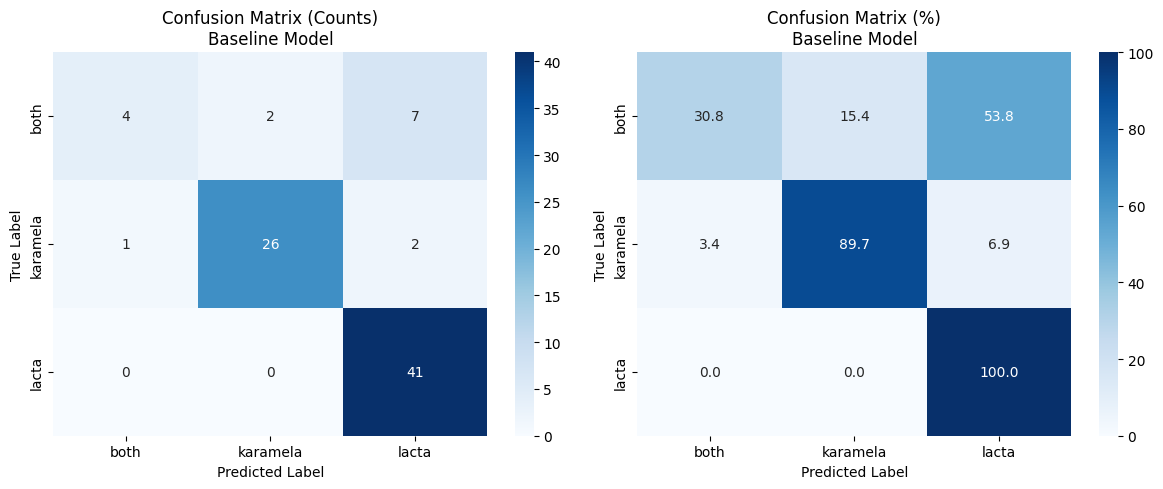

In [30]:
print("=== LOADING BEST MODEL FOR EVALUATION ===")
model_0 = tf.keras.models.load_model(os.path.join(MODEL_PATH, 'baseline_model_0.keras'))

evaluate_model(model_0, test_generator, baseline_classes.keys())

Overall Performance Assessment
Our baseline CNN model achieves strong overall performance with 85.5% test accuracy, demonstrating that the fundamental architecture is well-suited for this cat classification task. However, the per-class metrics reveal significant challenges with class imbalance.

Key Findings
Strengths
Excellent Accuracy: 85.5% overall accuracy significantly exceeds random chance (33.3%)

High Precision: 89.9% precision indicates reliable positive predictions

Strong Majority Class Performance: Near-perfect performance on the largest class:

Lacta: 100% recall - never misses Lacta when she's present

Karamela: 89.7% recall - very reliable detection

Critical Weakness - Class Imbalance Impact
The model struggles significantly with the underrepresented "both" class:

Very Low Recall (30.8%): Misses ~70% of images containing both cats

Moderate Precision (80.0%): When it predicts "both", it's usually correct

Poor F1-score (44.4%): Overall weak performance on this class

Performance Analysis
Macro vs Weighted Averages:

Macro F1 (75.3%): Treats all classes equally, showing imbalance penalty

Weighted F1 (83.4%): Weighted by support, reflects overall performance

Recall-Precision Trade-off: High precision (89.9%) but lower recall (74.7%) suggests conservative predictions

Implications for Next Steps
This evaluation clearly identifies our primary challenge: improving detection of the "both" class. The baseline model effectively learns to distinguish individual cats but fails to reliably recognize when both are present together, likely due to:

Limited training examples for the "both" class (only 59 training images)

Model bias toward majority classes

Potential feature overlap between single-cat and both-cat scenarios

This provides clear direction for model improvements - we need techniques specifically addressing class imbalance in the next phase of our project.

The learning curves reveal a baseline model that achieved modest but meaningful performance. With final training accuracy of 46.6% and validation accuracy of 48.2%, the model demonstrates it can learn to distinguish between our cats better than random chance (33.3%), though substantial improvement potential remains.

The close alignment between training and validation metrics (48.2% vs 46.6% accuracy, 0.993 vs 1.027 loss) indicates good generalization without significant overfitting—a positive sign given our limited dataset. The consistent downward trend in both training and validation loss suggests the model was still learning when training concluded, potentially benefiting from additional epochs.